In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
import cv2
import math
import time
import numbers
import random
import itertools
import warnings
import pydot as pyd
import seaborn as sns
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.colors as colors

warnings.simplefilter(action = 'ignore', category = FutureWarning)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";

# GPUid to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-04-14 13:30:03.932841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-14 13:30:05.487957: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-14 13:30:05.488584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-14 13:30:05.504377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:30:05.504567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-04-14 13:30:05.504584: I tensorflow/stream_executor/platform

In [4]:
# Data augmentation techniques
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    #x = tf.image.random_hue(x, 0.08)
    #x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.5)
    #x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

# def rotate(x: tf.Tensor) -> tf.Tensor:
#     """Rotation augmentation

#     Args:
#         x: Image

#     Returns:
#         Augmented image
#     """

#     return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))


# Utilities
def str_to_integer_label(str_labels, unique_labels = None):
    '''
    Converts a list of string based labels to integers
    '''
    if unique_labels is None:
        unique_labels = list(set(str_labels))
        unique_labels.sort()

    int_labels = [unique_labels.index(l) for l in str_labels]
    return int_labels

def deconde_resize_stack(sample, input_size = (200,200), channels = 1):
    # decode all the images for one sample
    aus = []
    for idx in range(sample.get_shape()[0]):
        # decode image
        tmp = tf.io.decode_image(tf.io.read_file(sample[idx]), channels = channels, expand_animations = False)
        # resize
        tmp = tf.image.resize(tmp, size = input_size, method = tf.image.ResizeMethod.BILINEAR)
        # remove unnecessary dimension
        tmp = tf.squeeze(tmp)
        # append to the list
        aus.append(tmp)
    
    # check nr of channels
    if len(aus) == 2:
        aus.append(tmp)
    elif len(aus) == 1:
        aus.append(tmp)
        aus.append(tmp)

    # stack images as channels and return
    return tf.stack(aus, axis = -1)


def data_gen(img_files,
             unique_labels = None,
             batch_size = 1,
             training = True,
             augmentation = True,
             channels = 1,
             input_size = (200, 200),
             normalize = True,
             normalization_strategy = 1,
             categorical = False):
    '''
    Script that uses given a list of samples, each containing the path to the
    images to load, creates a data generator usable by a tensorflow models

    INPUT
    img_files : list
        List of sample where each sample contains the paths to the image or images
        to be loabed as one sample. This can be:
        ¤ one modality: [ [path/to/sample_1], [path/to/sample_2], [path/to/sample_3], ... ]
        ¤ three modality: [ [path/to/sample_1_mod_1, path/to/sample_1_mod_2, path/to/sample_1_mod_3],
                            [path/to/sample_2_mod_1, path/to/sample_2_mod_2, path/to/sample_2_mod_3],
                            ... ,
                          ]
    unique_labels : list
        list of strings containing the unique labels to use for the classification
        E.g. ['G2', 'G3', 'G4']
    batch_size : int
    training : boolean
        If True, the dataset is considered as a training dataset thus shuffling
        is performed. Shuffling (and data augmentation) should turned off
        when generating a testing dataset.
    channels : int
        Number of channel of every image in one sample. This variable is used by
        the tf decoder (channels = 3 for and RGB image)
    input_size : tuple or list of int
    normalize : boolean
        True if normalization should be applied
    normalization_strategy : int
        Select on of the implemented normalization strategies. As for now:
        ¤ 1 -> [-1,1]
        ¤ 2 -> [0,1]
    categorical : boolean
        True if labels should be returned as categorical.
    '''
    # get string labels from the file names (assuming .../LABEL/FILE_0001.extension)
    str_labels = [os.path.basename(os.path.dirname(sample[0])) for sample in img_files]
    # convert to integer labels
    int_labels = str_to_integer_label(str_labels)
    # convert to categorical if needed
    if categorical:
        if unique_labels:
            int_labels = tf.one_hot(int_labels, len(unique_labels))
        else:
            print(f'No unique labels were provided. Skipping to_categorical transformation.')

    # create tf dataset. This will loop through all the image files that are given
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(img_files), tf.constant(int_labels)))

    # Open the images
    # this is the tricky part where we concatenate the different modalities together
    dataset = dataset.map(tf.autograph.experimental.\
                          do_not_convert(lambda x, y: (deconde_resize_stack(x, input_size = input_size, 
                                                                            channels = channels), y)))

    # crop to specified input size
    # dataset = dataset.map(tf.autograph.experimental.\
                            #do_not_convert(lambda x, y: (tf.image.resize(x, size = input_size, 
                                                                         #method = tf.image.ResizeMethod.BILINEAR), y)))
    
    #dataset = dataset.map(lambda x,y: (tf.divide(x, 191.25) - 1.0, y)) 
    
    # Set up dataset
    AUTOTUNE = tf.data.AUTOTUNE # find number of cpu's to use
    if training is True:
        dataset = dataset.shuffle(500)
    if augmentation:
        # Add augmentations
        augmentations = [flip, color]
        for f in augmentations:
            dataset = dataset.map(lambda x,y: (tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: f(x), lambda: x),y), num_parallel_calls=4)
            
    
    dataset = dataset.map(lambda x,y: (tf.divide(x, 191.25) - 1.0, y)) 
    dataset = dataset.prefetch(buffer_size = AUTOTUNE)
    dataset = dataset.batch(batch_size = batch_size)
    dataset = dataset.repeat()

    return dataset, str_labels, int_labels

In [5]:
# Get file paths for train/val/test
image_files_train = []
for roots, dirs, files in os.walk('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_t2_flair_sagittal (Backup) (copy)/train'):
    for name in files:
        if name.endswith('.png'):
            image_files_train.append(roots + os.path.sep + name)
            
image_files_train = [[i]*3 for i in image_files_train]

image_files_valid = []
for roots, dirs, files in os.walk('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_t2_flair_sagittal (Backup) (copy)/val'):
    for name in files:
        if name.endswith('.png'):
            image_files_valid.append(roots + os.path.sep + name)
            
image_files_valid = [[i]*3 for i in image_files_valid]

image_files_test = []
for roots, dirs, files in os.walk('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_t2_flair_sagittal (Backup) (copy)/test'):
    for name in files:
        if name.endswith('.png'):
            image_files_test.append(roots + os.path.sep + name)
            
image_files_test = [[i]*3 for i in image_files_test]

# Create generator
train = data_gen(image_files_train,
                 unique_labels = ['G2', 'G3', 'G4'],
                 batch_size = 64, 
                 channels = 1, 
                 input_size = (224, 224), 
                 categorical = True,
                 training = True, 
                 augmentation = True)

validation = data_gen(image_files_valid,
                      unique_labels = ['G2', 'G3', 'G4'],
                      batch_size = 64, 
                      channels = 1, 
                      input_size = (224, 224), 
                      categorical = True,
                      training = False, 
                      augmentation = False)

test = data_gen(image_files_test,
                unique_labels = ['G2', 'G3', 'G4'],
                batch_size = 64, 
                channels = 1, 
                input_size = (224, 224), 
                categorical = True,
                training = False, 
                augmentation = False)

2022-04-14 13:30:22.020197: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 13:30:22.022153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:30:22.022326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-04-14 13:30:22.022352: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library 

2022-04-14 13:30:26.098180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-14 13:30:26.100128: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4100000000 Hz


(64, 224, 224, 3) (64, 3)
-1.002319 0.32287586


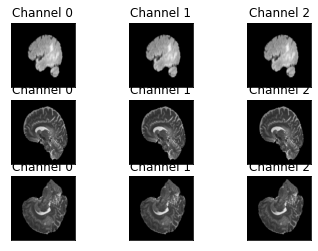

In [6]:
# Take out one sample
x, y = next(iter(train[0]))
x = x.numpy()
y = y.numpy()
print(x.shape, y.shape)
print(x.min(), x.max())
# Use gen and print images from the different channels
n_cols = x.shape[-1]
n_rows = 3

fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols)
for idx, ax in enumerate(axs):
    # print all the channels separately for every sample
    for c in range(n_cols):
        ax[c].imshow(x[idx, :,:,c], cmap = 'gray', interpolation = None)
        ax[c].set_title(f'Channel {c}')
        ax[c].set_xticks([])
        ax[c].set_yticks([])
plt.show()

In [7]:
# Convert list of classes to NumPy ndarray
classes = np.argmax(np.asarray(train[2]),axis = -1)
valid_classes = np.argmax(np.asarray(validation[2]), axis = -1)
test_classes = np.argmax(np.asarray(test[2]), axis = -1)

In [ ]:
# Insert initial parameters
batch_size = 64
img_height, img_width = 224, 224
n_classes = 3

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip = False, 
                                   vertical_flip = False,
                                   brightness_range = [0.5, 1.25],
                                   samplewise_center = True,
                                   rescale = 1./255)
#                                    preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(horizontal_flip = False, 
                                  vertical_flip = False,
                                  rotation_range = 0,
                                  samplewise_center = True,
                                  rescale = 1./255)
#                                   preprocessing_function = preprocess_input)

train = train_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_t2_flair_sagittal/train', 
                                          classes = ['G2','G3','G4'], color_mode = 'rgb', 
                                          class_mode = 'categorical', 
                                          target_size = (img_height, img_width), 
                                          batch_size = batch_size, seed = 123)
validation = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_t2_flair_sagittal/val', 
                                              classes = ['G2','G3','G4'], color_mode = 'rgb',
                                              class_mode = 'categorical', 
                                              target_size = (img_height, img_width), 
                                              batch_size = batch_size, seed = 123)
test = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_t2_flair_sagittal/test', 
                                        classes = ['G2','G3','G4'], color_mode = 'rgb',
                                        shuffle = False, class_mode = 'categorical', 
                                        target_size = (img_height, img_width), 
                                        batch_size = batch_size)

In [8]:
# Use class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(classes), 
                                                  y = classes)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))

In [ ]:
x_train, y_train = next(iter(train))
print(x_train.shape, y_train.shape)
print(x_train.min())

# Plot the images for fun
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in enumerate(axes):
        ax.imshow(images[img,:,:], cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(x_train[:1000])

In [ ]:
# Load base model
resnet_50 = ResNet50(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

n_classes = 3
freeze_until_layer = 100

# Freeze all layers before the `freeze_until_layer` layer
for layer in resnet_50.layers[:-freeze_until_layer]:
    layer.trainable = False

x = resnet_50.output
x = Flatten()(x)
x = Dense(25, activation = 'relu')(x)
x = Dropout(0.3)(x)
# x = BatchNormalization()(x)
predictions = Dense(n_classes, activation = 'softmax')(x)

model = Model(inputs = resnet_50.input, outputs = predictions)
model.summary()

In [9]:
# Load base model
input_ = tf.keras.layers.Input(shape=(224,224,3))

x = Conv2D(filters= 64, kernel_size=(5,5), padding='valid')(input_)
x = Conv2D(filters= 64,kernel_size=(5,5), padding='valid')(x)
x = tf.keras.activations.relu(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)


x = Conv2D(filters= 128,kernel_size=(5,5), padding='valid')(x)
x = Conv2D(filters= 128 ,kernel_size=(5,5), padding='valid')(x)
x = tf.keras.activations.relu(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=256 ,kernel_size=(5,5), padding='valid')(x)
x = Conv2D(filters=256 ,kernel_size=(5,5), padding='valid')(x)
x = tf.keras.activations.relu(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(25, activation = 'relu')(x)
x = Dropout(0.3)(x)
# x = BatchNormalization()(x)
predictions = Dense(3, activation = 'softmax')(x)

model = Model(inputs = input_, outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 220, 220, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 64)      102464    
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 216, 216, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 128)     204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 128)     409728

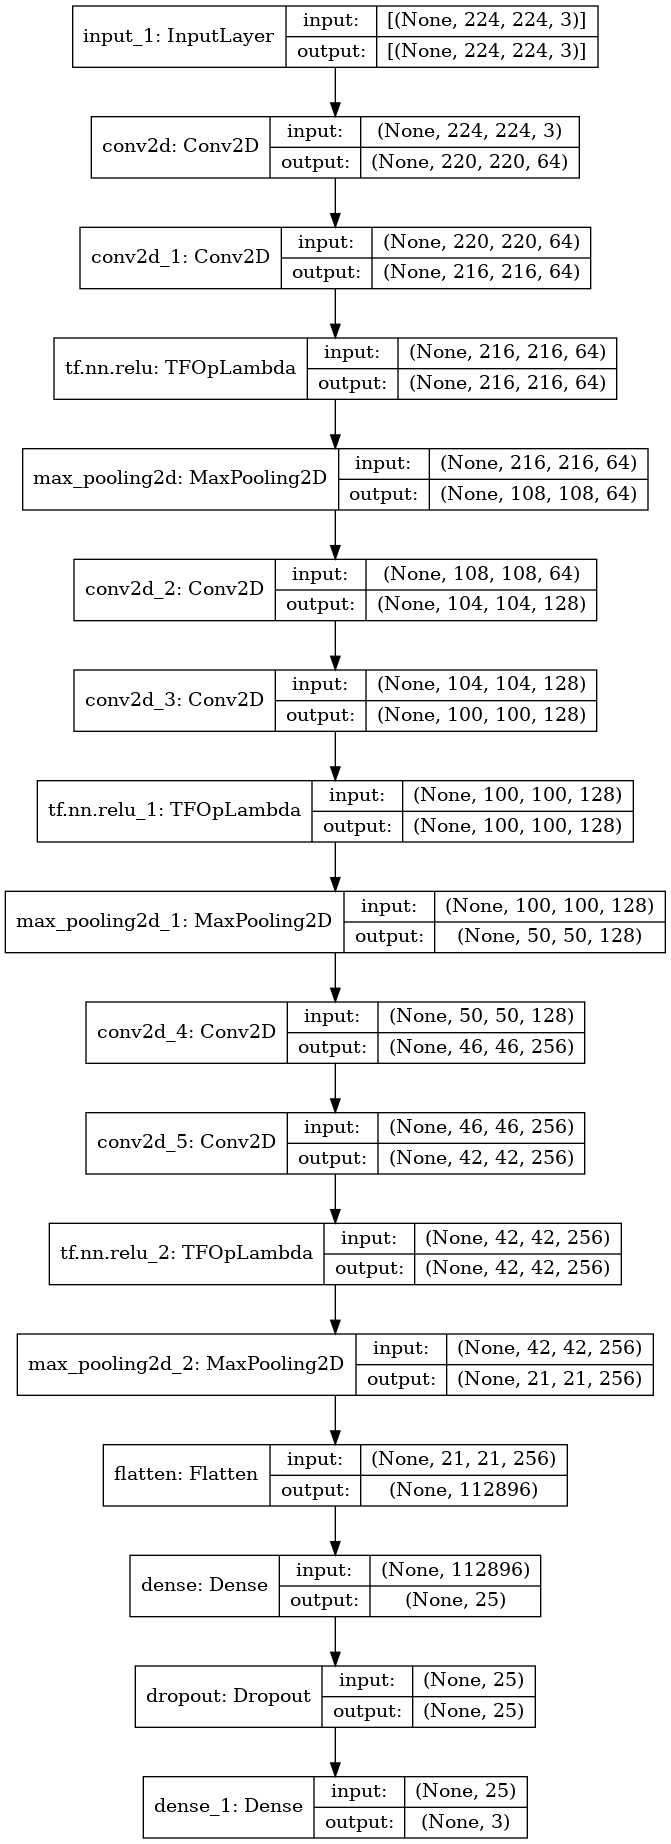

In [10]:
plot_model(model, to_file = 'resnet50_plot_t1ce_t2_flair_sagittal_2nd.png', show_shapes = True, show_layer_names = True)

In [11]:
# Save best model
checkpoint_path = '/local/data1/elech646/code/train_logs/resnet50_transfer_t1ce_t2_flair_sagittal_2nd.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                verbose = 1,
                                                save_best_only = True)

# Save log for history
# append: True: append if file exists (useful for continuing training)//False: overwrite existing file
csv_logger = CSVLogger('/local/data1/elech646/code/train_logs/resnet50_transfer_history_t1ce_t2_flair_sagittal_2nd.log', 
                       separator = ',', append = True)

# Reduce learning rate if val_accuracy is not improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1,
                              patience = 5, min_lr = 0.000001)
es = EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                   patience = 15)

In [12]:
# Compile model
model.compile(Adam(lr = 1e-3),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

epochs = 30
batch_size = 64
start = timer()

history = model.fit(train[0], steps_per_epoch = len(classes) // batch_size, verbose = 1,
                    epochs = epochs, validation_data = validation[0],
                    validation_steps = len(valid_classes) // batch_size,
                    callbacks = [es, checkpoint, csv_logger])

end = timer()
print("Training time: %.2f s\n" % (end - start))

Epoch 1/30


2022-04-14 13:30:51.697580: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-14 13:30:52.466250: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-14 13:30:54.962544: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


211/211 [==============================] - 56s 249ms/step - loss: 21.2713 - accuracy: 0.9132 - val_loss: 1.1506 - val_accuracy: 0.2608

Epoch 00001: val_accuracy improved from -inf to 0.26082, saving model to /local/data1/elech646/code/train_logs/resnet50_transfer_t1ce_t2_flair_sagittal_2nd.h5
Epoch 2/30
211/211 [==============================] - 53s 250ms/step - loss: 1.1707 - accuracy: 0.1641 - val_loss: 1.1073 - val_accuracy: 0.2608

Epoch 00002: val_accuracy did not improve from 0.26082
Epoch 3/30
211/211 [==============================] - 52s 249ms/step - loss: 1.0984 - accuracy: 0.1463 - val_loss: 1.0892 - val_accuracy: 0.2608

Epoch 00003: val_accuracy did not improve from 0.26082
Epoch 4/30
211/211 [==============================] - 53s 249ms/step - loss: 1.0668 - accuracy: 0.2651 - val_loss: 1.0759 - val_accuracy: 0.2608

Epoch 00004: val_accuracy did not improve from 0.26082
Epoch 5/30
211/211 [==============================] - 53s 251ms/step - loss: 1.0456 - accuracy: 0.4575

In [ ]:
len(valid_classes)

1st training:  

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(25, activation = 'relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64 

number of epochs = 30

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 801.88 s $\approx 13$ min

test accuracy: 0.6283 (overfit)

In [13]:
score = model.evaluate(test[0], steps = len(test_classes) // batch_size, verbose = 0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.0516
Test accuracy: 0.4268


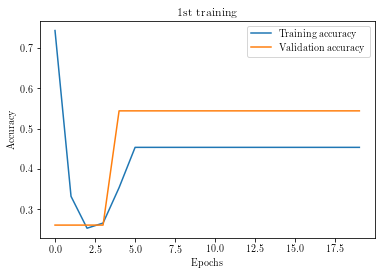

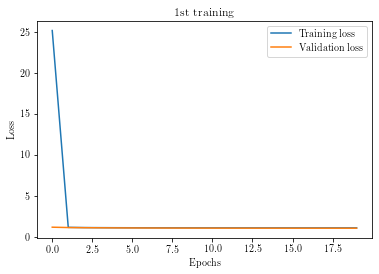

In [15]:
# Plot training + validation accuracy per epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = range(len(acc))

# for fancy LaTeX style plots
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex = True)

# Plot accuracy
plt.plot(n_epochs, acc, label = 'Training accuracy')
plt.plot(n_epochs, val_acc, label = 'Validation accuracy')
plt.title('1st training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
#plt.savefig('ResNet50_1st_training_t1ce_t2_flair_sagittal_acc.png', dpi = 300)
plt.show()

# Plot loss
plt.plot(n_epochs, loss, label = 'Training loss')
plt.plot(n_epochs, val_loss, label = 'Validation loss')
plt.title('1st training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
#plt.savefig('ResNet50_1st_training_t1ce_t2_flair_sagittal_loss.png', dpi = 300)
plt.show()

In [ ]:
# Get true labels
y_true = test_classes

# Get rounded predictions
y_pred = np.argmax(model.predict(test), axis = 1) 

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

#ax = sns.heatmap(cm, annot = True, cmap = 'Blues')
ax = sns.heatmap(cm / np.sum(cm), annot = True, fmt = '.2%', cmap = 'PuBu')
for t in ax.texts: 
    t.set_text(t.get_text().replace('%', '\%'))
ax.set_xlabel('\nPredicted values')
ax.set_ylabel('Actual values ');
# list must be in alphabetical order
ax.xaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
ax.yaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
plt.savefig('1st_Training_CM_t1ce_t2_flair_sagittal.png', dpi = 300)
plt.show()

In [ ]:
# Print classification report
print(classification_report(y_true, y_pred))

# # Save the classification report
# clsf_report = pd.DataFrame(classification_report(y_true = y_true, y_pred = y_pred, output_dict = True)).transpose()
# clsf_report.to_csv('Classification Report-1st Training on t1ce_t2_flair sagittal.csv', index = True)